# Bandit Problems

Given $k$ options, which option is the best?

For option $i$, receive $r_i \sim B_i$

Want to get to the optimal policy ASAP


---



# Exploration vs Exploitation

![alt](https://img.memecdn.com/guild-wars-2-the-gift-of-exploration_o_1137524.jpg)

## Need to understand the reward from each option, under constraints of minimizing regret

---

# $\epsilon$-Greedy algorithms

Simple way to trade off between explore and exploit

In [239]:
import warnings
warnings.filterwarnings('ignore')
import gym_bandits
import gym
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_context('talk')
sns.set_palette('colorblind')

To understand the ideas behind bandits, we're going to play with [gym-bandit's 10-armed Gaussian Bandit](https://github.com/JKCooper2/gym-bandits)  

Each bandit has a Normal Distributed reward wiht a given mean and standard deviation

We'll show each distribution with `env.r_dist`

In [240]:
env = gym.make("BanditTenArmedGaussian-v0")

[2017-05-19 15:09:55,821] Making new env: BanditTenArmedGaussian-v0


In [241]:
env.r_dist

[[0.9651344923418992, 1],
 [-1.8501439929981383, 1],
 [-0.8569947182105938, 1],
 [0.045580041053470265, 1],
 [1.686776719581437, 1],
 [-2.9745849786824947, 1],
 [0.7118043478500182, 1],
 [-0.49083459106355487, 1],
 [-0.028259223298342982, 1],
 [-0.4251313067561255, 1]]

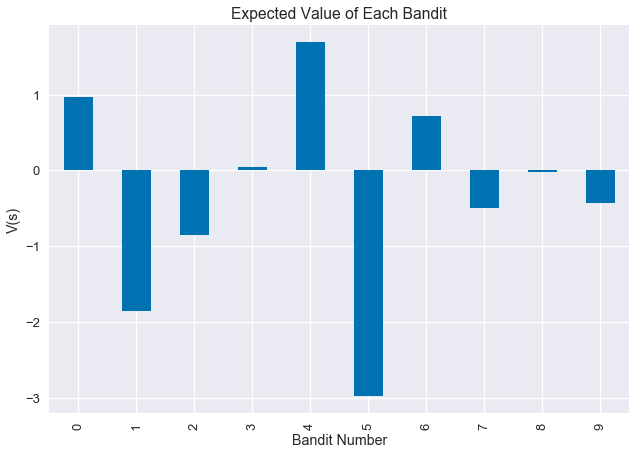

In [242]:
bandit_means = pd.Series([b[0] for b in env.r_dist])
bandit_means.plot(kind='bar')
plt.title('Expected Value of Each Bandit')
plt.ylabel('V(s)')
plt.xlabel('Bandit Number')

Which bandit should we pick?

In [243]:
bandit_means.idxmax()

4

We'll first use a simple stochastic policy with a fixed epsilon $\epsilon = .1$

In [244]:
iterations = 1000
epsilon = .1
policy = env.action_space.sample()
bandit_data = pd.DataFrame(index=(range(iterations)), columns=['arm', 'reward', 'epsilon', 'regret', 'policy', 'random_policy'])
bandit_data['reward'] = bandit_data['reward'].astype('float')

In [245]:
for i in range(iterations):
    if np.random.binomial(1, epsilon):
        arm = env.action_space.sample()
    else:
        arm = policy
    reward = env.step(arm)[1]
    regret = i*bandit_means.max() - bandit_data['reward'].ix[:i].sum()
    bandit_data.ix[i] = pd.Series(data=[arm, reward, epsilon, regret, policy, arm != policy], index=list(bandit_data.columns))
    policy = int(bandit_data.ix[:i].groupby('arm')['reward'].mean().idxmax())

In [246]:
bandit_data.head()

,arm,reward,epsilon,regret,policy,random_policy
0,6,2.188479,0.1,0,6,False
1,1,-1.820562,0.1,-0.501702,6,True
2,6,1.137042,0.1,3.00564,6,False
3,6,1.882008,0.1,3.55537,6,False
4,6,0.428198,0.1,3.36014,6,False


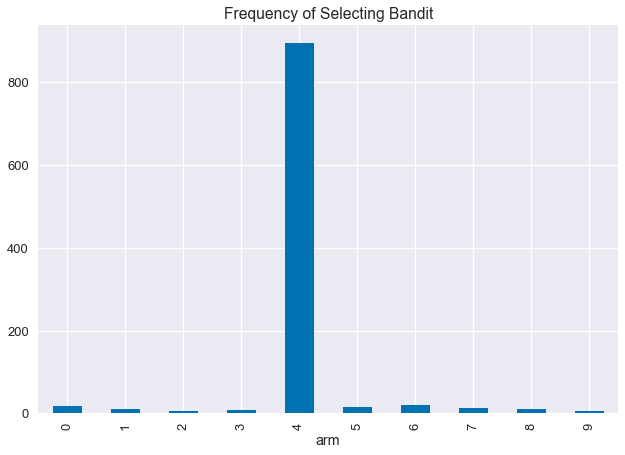

In [247]:
arm_counts = bandit_data.groupby('arm')['epsilon'].count()
arm_counts.index = arm_counts.index.astype(int)
ax = arm_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Frequency of Selecting Bandit')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

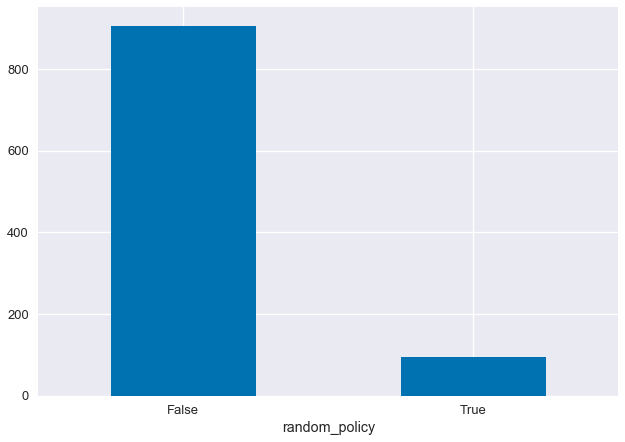

In [248]:
bandit_data.groupby('random_policy')['epsilon'].count().plot(kind='bar')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

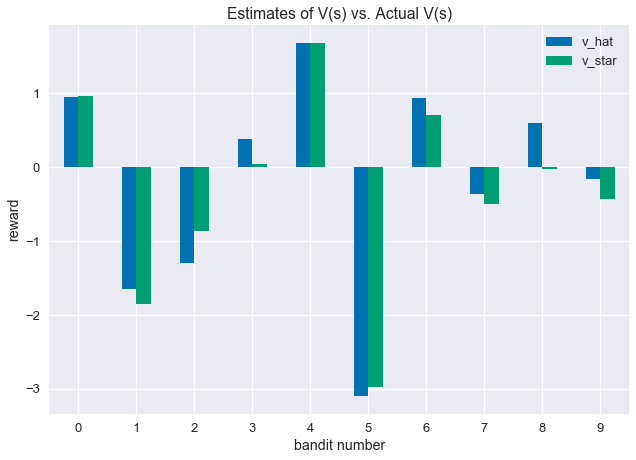

In [249]:
v_values = pd.DataFrame(bandit_data.groupby('arm')['reward'].mean()).join(pd.DataFrame(bandit_means), how='outer')
v_values.columns = ['v_hat', 'v_star']
v_values.plot(kind='bar')
plt.title('Estimates of V(s) vs. Actual V(s)')
plt.xlabel('bandit number')
plt.ylabel('reward')
plt.xticks(rotation=0)

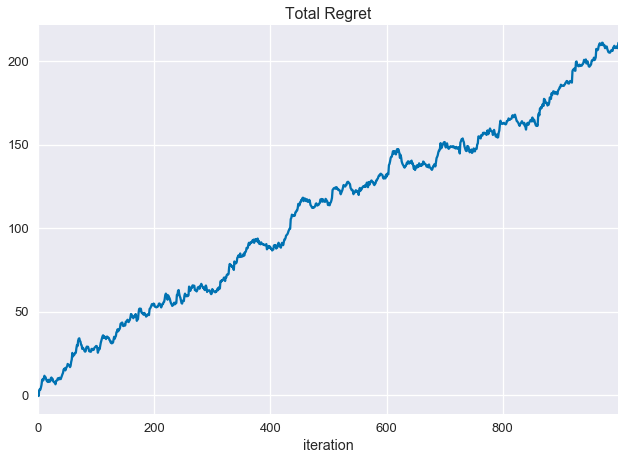

In [250]:
bandit_data['regret'].plot()
plt.title('Total Regret')
plt.xlabel('iteration')

## $\epsilon$-greedy has linear regret 

## To get sublinear regret, we would have to tune down $\epsilon$ so we converge to a greedy policy

In [251]:
iterations = 1000
epsilon = .1
policy = env.action_space.sample()
old_regret = bandit_data['regret']
bandit_data = pd.DataFrame(index=(range(iterations)), columns=['arm', 'reward', 'epsilon', 'regret', 'policy', 'random_policy'])
bandit_data['reward'] = bandit_data['reward'].astype('float')

for i in range(iterations):
    if np.random.binomial(1, epsilon):
        arm = env.action_space.sample()
    else:
        arm = policy
    reward = env.step(arm)[1]
    regret = i*bandit_means.max() - bandit_data['reward'].ix[:i].sum()
    bandit_data.ix[i] = pd.Series(data=[arm, reward, epsilon, regret, policy, arm != policy], index=list(bandit_data.columns))
    policy = int(bandit_data.ix[:i].groupby('arm')['reward'].mean().idxmax())
    epsilon = 1./((i/50) + 10)

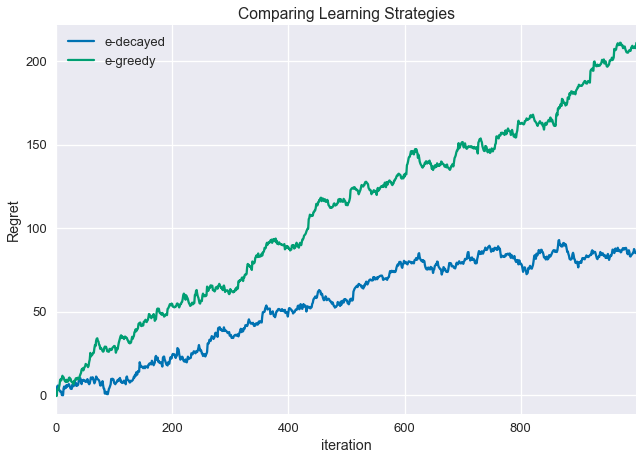

In [252]:
regret_comp = pd.DataFrame(bandit_data['regret']).join(pd.DataFrame(old_regret), lsuffix='new', rsuffix='old')
regret_comp.columns = ['e-decayed', 'e-greedy']
regret_comp.plot()
plt.title('Comparing Learning Strategies')
plt.ylabel('Regret')
plt.xlabel('iteration')